# 2025 MCM*

# Problem C:Models for Olympic Medal Tables

**Import Required Packages**

In [16]:
# Import Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

**Load Datasets**

In [19]:
athletes_data = pd.read_csv("summerOly_athletes.csv", encoding="ISO-8859-1")
hosts_data = pd.read_csv("summerOly_hosts.csv", encoding="ISO-8859-1")
medal_counts_data = pd.read_csv("summerOly_medal_counts.csv", encoding="ISO-8859-1")
programs_data = pd.read_csv("summerOly_programs.csv", encoding="ISO-8859-1")

# Display the first 2 rows of each dataset
print("Athletes Data:\n", athletes_data.head(2))
print("\nHosts Data:\n", hosts_data.head(2))
print("\nMedal Counts Data:\n", medal_counts_data.head(2))
print("\nPrograms Data:\n", programs_data.head(2))

Athletes Data:
         Name Sex   Team  NOC  Year       City       Sport  \
0  A Dijiang   M  China  CHN  1992  Barcelona  Basketball   
1   A Lamusi   M  China  CHN  2012     London        Judo   

                          Event     Medal  
0   Basketball Men's Basketball  No medal  
1  Judo Men's Extra-Lightweight  No medal  

Hosts Data:
    ï»¿Year               Host
0     1896  Â Athens,Â Greece
1     1900   Â Paris,Â France

Medal Counts Data:
    Rank            NOC  Gold  Silver  Bronze  Total  Year
0     1  United States    11       7       2     20  1896
1     2         Greece    10      18      19     47  1896

Programs Data:
       Sport         Discipline Code Sports Governing Body 1896 1900 1904  \
0  Aquatics  Artistic Swimming  SWA        World Aquatics    0    0    0   
1  Aquatics             Diving  DIV        World Aquatics    0    0    2   

   1906*  1908 1912  ...  1988 1992 1996 2000 2004 2008  2012 2016  2020 2024  
0      0     0    0  ...     2    2  1.0  2

**Exploratory Data Analysis**

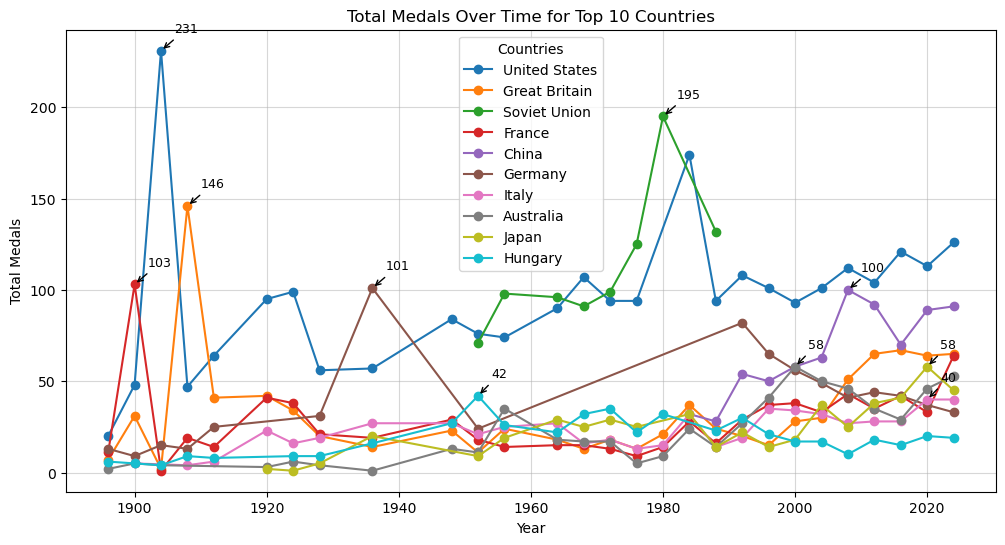

In [29]:
# Plot 1: Medal trends over time
plt.figure(figsize=(12, 6))
top_countries = medal_counts_data.groupby('NOC')['Total'].sum().nlargest(10).index
colors = sns.color_palette("tab10", len(top_countries))  # Gradient palette for countries

for i, country in enumerate(top_countries):
    country_data = medal_counts_data[medal_counts_data['NOC'] == country]
    plt.plot(country_data['Year'], country_data['Total'], label=country, marker='o', color=colors[i])
    
    # Annotate peak performance year
    peak_year = country_data.loc[country_data['Total'].idxmax()]
    plt.annotate(f"{peak_year['Total']}", 
                 xy=(peak_year['Year'], peak_year['Total']),
                 xytext=(peak_year['Year'] + 2, peak_year['Total'] + 10),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9)

plt.xlabel('Year')
plt.ylabel('Total Medals')
plt.title('Total Medals Over Time for Top 10 Countries')
plt.legend(title="Countries")
plt.grid(alpha=0.5)
plt.show()

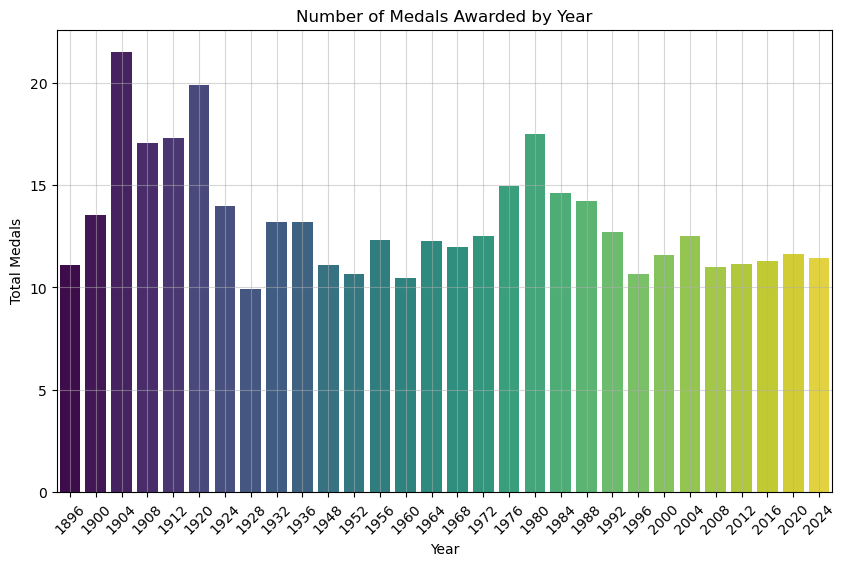

In [23]:
# Plot 2: Medal Distribution by Year
# Plot 2: Medal Distribution by Year
plt.figure(figsize=(10, 6))

# Updated barplot with errorbar=None and hue for the palette
bar = sns.barplot(data=medal_counts_data, x="Year", y="Total", hue="Year", dodge=False, palette="viridis", errorbar=None)
plt.legend([], [], frameon=False)  # Remove redundant legend caused by `hue`

# Annotate highest and lowest points
medal_counts_by_year = medal_counts_data.groupby("Year")["Total"].sum()
max_year = medal_counts_by_year.idxmax()
min_year = medal_counts_by_year.idxmin()

plt.annotate(f"Highest: {medal_counts_by_year[max_year]}",
             xy=(max_year, medal_counts_by_year[max_year]),
             xytext=(max_year + 1, medal_counts_by_year[max_year] + 10),
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             fontsize=9)

plt.annotate(f"Lowest: {medal_counts_by_year[min_year]}",
             xy=(min_year, medal_counts_by_year[min_year]),
             xytext=(min_year - 2, medal_counts_by_year[min_year] - 10),
             arrowprops=dict(facecolor='red', arrowstyle='->'),
             fontsize=9)

plt.xticks(rotation=45)
plt.title("Number of Medals Awarded by Year")
plt.ylabel("Total Medals")
plt.xlabel("Year")
plt.grid(alpha=0.5)
plt.show()

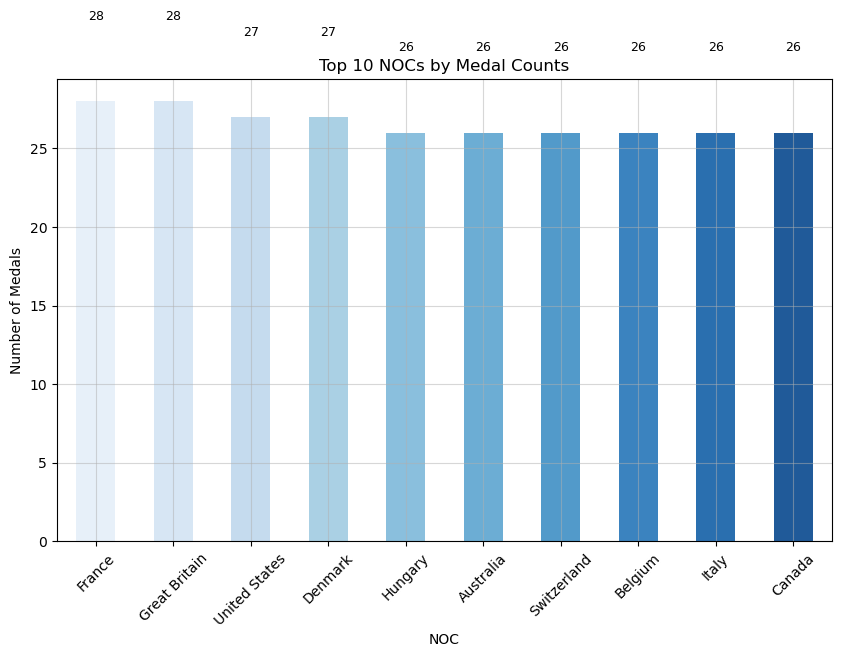

In [25]:
# Plot 3: Medal Distribution by NOC
top_noc = medal_counts_data['NOC'].value_counts().head(10)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues", len(top_noc))
bar = top_noc.plot(kind='bar', color=colors, alpha=0.9)

# Annotate bars
for i, value in enumerate(top_noc):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

plt.title("Top 10 NOCs by Medal Counts")
plt.ylabel("Number of Medals")
plt.xlabel("NOC")
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.show()

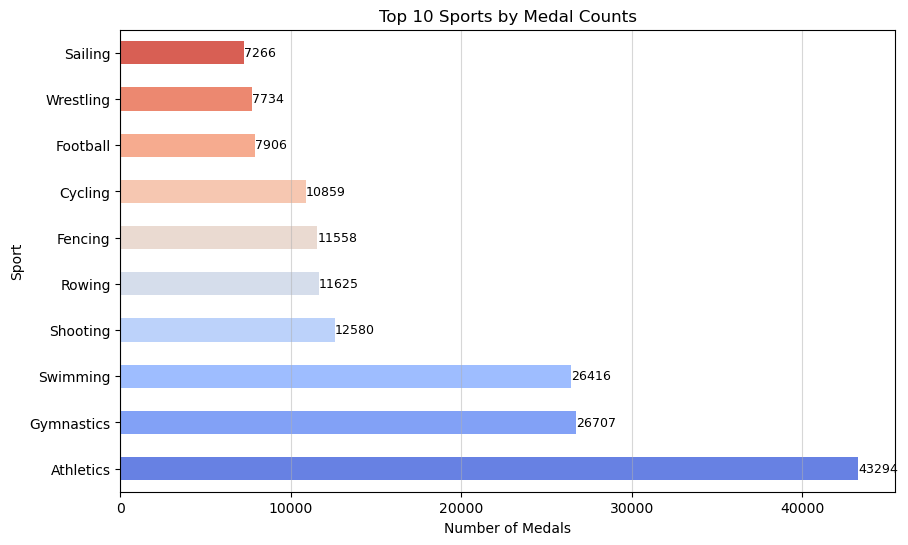

In [27]:
# Plot 4: Medal Counts by Sport
top_sports = athletes_data['Sport'].value_counts().head(10)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(top_sports))
bar = top_sports.plot(kind='barh', color=colors, alpha=0.9)

# Annotate bars
for i, value in enumerate(top_sports):
    plt.text(value + 5, i, str(value), va='center', fontsize=9)

plt.title("Top 10 Sports by Medal Counts")
plt.xlabel("Number of Medals")
plt.ylabel("Sport")
plt.grid(alpha=0.5, axis='x')
plt.show()

**Data Cleaning & Data Preparation**

In [53]:
### Data Cleaning & Data Preparation
# Fix encoding issue: Rename 'ï»¿Year' to 'Year'
hosts_data.rename(columns={'ï»¿Year': 'Year'}, inplace=True)

# Ensure the 'Year' column in both datasets is clean and consistent
hosts_data['Year'] = hosts_data['Year'].astype(str).str.strip()
medal_counts_data['Year'] = medal_counts_data['Year'].astype(str).str.strip()

# Merge medal counts with hosts for host country analysis
#medal_counts_data = medal_counts_data.merge(hosts_data, on="Year", how="left")

# Clean medal counts data
medal_counts_data["NOC"] = medal_counts_data["NOC"].str.strip()
hosts_data["Host"] = hosts_data["Host"].str.strip()

# Merge hosts data with medal counts data
medal_with_hosts = pd.merge(medal_counts_data, hosts_data, on="Year", how="left")

# Add a column indicating whether the country is the host
medal_with_hosts["Host_Country"] = medal_with_hosts["Host"].apply(lambda x: 1 if x and x.split(",")[0] in medal_with_hosts["NOC"].values else 0)

**Model 1 - Multiple Linear Regression**

In [56]:
from sklearn.model_selection import cross_val_score

# CELL: Question 1 - Medal Count Model (Gold and Total Medals)
# Prepare data for modeling
medal_counts_data['Gold'] = pd.to_numeric(medal_counts_data['Gold'], errors='coerce')
medal_counts_data['Total'] = pd.to_numeric(medal_counts_data['Total'], errors='coerce')
medal_counts_data.dropna(subset=['Gold', 'Total'], inplace=True)

X = medal_counts_data[['Year', 'Rank']]  # Using year and rank as predictors
y_gold = medal_counts_data['Gold']
y_total = medal_counts_data['Total']

# Train-test split
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=42)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Model training
gold_model = LinearRegression()
total_model = LinearRegression()

gold_model.fit(X_train_gold, y_train_gold)
total_model.fit(X_train_total, y_train_total)

# Predictions and evaluation
gold_predictions = gold_model.predict(X_test_gold)
total_predictions = total_model.predict(X_test_total)

gold_rmse = np.sqrt(mean_squared_error(y_test_gold, gold_predictions))
total_rmse = np.sqrt(mean_squared_error(y_test_total, total_predictions))

gold_r2 = r2_score(y_test_gold, gold_predictions)
total_r2 = r2_score(y_test_total, total_predictions)

print("\nGold Medals - RMSE:", gold_rmse, "R2:", gold_r2)
print("Total Medals - RMSE:", total_rmse, "R2:", total_r2)

# Cross-validation for Gold model
gold_cv_scores = cross_val_score(gold_model, X, y_gold, cv=5, scoring='neg_root_mean_squared_error')
gold_cv_mean_rmse = -gold_cv_scores.mean()
gold_cv_std = gold_cv_scores.std()

# Cross-validation for Total model
total_cv_scores = cross_val_score(total_model, X, y_total, cv=5, scoring='neg_root_mean_squared_error')
total_cv_mean_rmse = -total_cv_scores.mean()
total_cv_std = total_cv_scores.std()

print("\nGold Medals - Cross-Validation RMSE (Mean):", gold_cv_mean_rmse, "Std Dev:", gold_cv_std)
print("Total Medals - Cross-Validation RMSE (Mean):", total_cv_mean_rmse, "Std Dev:", total_cv_std)


Gold Medals - RMSE: 9.75336273624196 R2: 0.20319028687736262
Total Medals - RMSE: 23.77640996207622 R2: 0.21569517438917274

Gold Medals - Cross-Validation RMSE (Mean): 7.204859867683522 Std Dev: 1.2381177785250408
Total Medals - Cross-Validation RMSE (Mean): 18.26503590119392 Std Dev: 3.1393029156897025


**Model 2: Polynomial Regression**

In [59]:
# Polynomial Regression
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform features for training and testing
X_poly_train_gold = poly.fit_transform(X_train_gold)
X_poly_test_gold = poly.transform(X_test_gold)
X_poly_train_total = poly.fit_transform(X_train_total)
X_poly_test_total = poly.transform(X_test_total)

# Train and evaluate Polynomial Regression for Gold Medals
poly_gold_model = LinearRegression()
poly_gold_model.fit(X_poly_train_gold, y_train_gold)
poly_gold_predictions = poly_gold_model.predict(X_poly_test_gold)
poly_gold_rmse = np.sqrt(mean_squared_error(y_test_gold, poly_gold_predictions))
poly_gold_r2 = r2_score(y_test_gold, poly_gold_predictions)

# Train and evaluate Polynomial Regression for Total Medals
poly_total_model = LinearRegression()
poly_total_model.fit(X_poly_train_total, y_train_total)
poly_total_predictions = poly_total_model.predict(X_poly_test_total)
poly_total_rmse = np.sqrt(mean_squared_error(y_test_total, poly_total_predictions))
poly_total_r2 = r2_score(y_test_total, poly_total_predictions)

# Cross-validation for Polynomial Regression
poly_gold_model_cv = LinearRegression()
X_poly_gold_cv = poly.fit_transform(X)  # Apply polynomial transformation to the entire dataset
poly_gold_cv_predictions = cross_val_predict(poly_gold_model_cv, X_poly_gold_cv, y_gold, cv=5)
poly_gold_cv_rmse = np.sqrt(mean_squared_error(y_gold, poly_gold_cv_predictions))

poly_total_model_cv = LinearRegression()
X_poly_total_cv = poly.fit_transform(X)
poly_total_cv_predictions = cross_val_predict(poly_total_model_cv, X_poly_total_cv, y_total, cv=5)
poly_total_cv_rmse = np.sqrt(mean_squared_error(y_total, poly_total_cv_predictions))

# Display results
print("\nGold Medals - Polynomial Regression (Train-Test): RMSE:", poly_gold_rmse, "R2:", poly_gold_r2)
print("Gold Medals - Polynomial Regression (Cross-Validation): RMSE:", poly_gold_cv_rmse)

print("\nTotal Medals - Polynomial Regression (Train-Test): RMSE:", poly_total_rmse, "R2:", poly_total_r2)
print("Total Medals - Polynomial Regression (Cross-Validation): RMSE:", poly_total_cv_rmse)



Gold Medals - Polynomial Regression (Train-Test): RMSE: 8.556966574169659 R2: 0.38668224413761676
Gold Medals - Polynomial Regression (Cross-Validation): RMSE: 6.311954168377956

Total Medals - Polynomial Regression (Train-Test): RMSE: 20.71172300528933 R2: 0.40485226534168306
Total Medals - Polynomial Regression (Cross-Validation): RMSE: 15.761017468435135


**Model 3: Ridge Regression**

In [62]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Regularization strength
ridge_model.fit(X_train_gold, y_train_gold)
ridge_gold_predictions = ridge_model.predict(X_test_gold)
ridge_gold_rmse = np.sqrt(mean_squared_error(y_test_gold, ridge_gold_predictions))
ridge_gold_r2 = r2_score(y_test_gold, ridge_gold_predictions)

ridge_total_predictions = ridge_model.predict(X_test_total)
ridge_total_rmse = np.sqrt(mean_squared_error(y_test_total, ridge_total_predictions))
ridge_total_r2 = r2_score(y_test_total, ridge_total_predictions)

# Cross-validation for Ridge
ridge_cv_gold = cross_val_score(ridge_model, X_train_gold, y_train_gold, scoring='neg_root_mean_squared_error', cv=5)
ridge_cv_total = cross_val_score(ridge_model, X_train_total, y_train_total, scoring='neg_root_mean_squared_error', cv=5)

# Display results
print("\nGold Medals - Ridge Regression: RMSE:", ridge_gold_rmse, "R2:", ridge_gold_r2)
print("Gold Medals - Cross-Validation RMSE:", -ridge_cv_gold.mean())

print("\nTotal Medals - Ridge Regression: RMSE:", ridge_total_rmse, "R2:", ridge_total_r2)
print("Total Medals - Cross-Validation RMSE:", -ridge_cv_total.mean())


Gold Medals - Ridge Regression: RMSE: 9.753363361143336 R2: 0.20319018477360296
Gold Medals - Cross-Validation RMSE: 6.0910838966225755

Total Medals - Ridge Regression: RMSE: 26.702077512662097 R2: 0.01080381943713693
Total Medals - Cross-Validation RMSE: 15.91963653100196


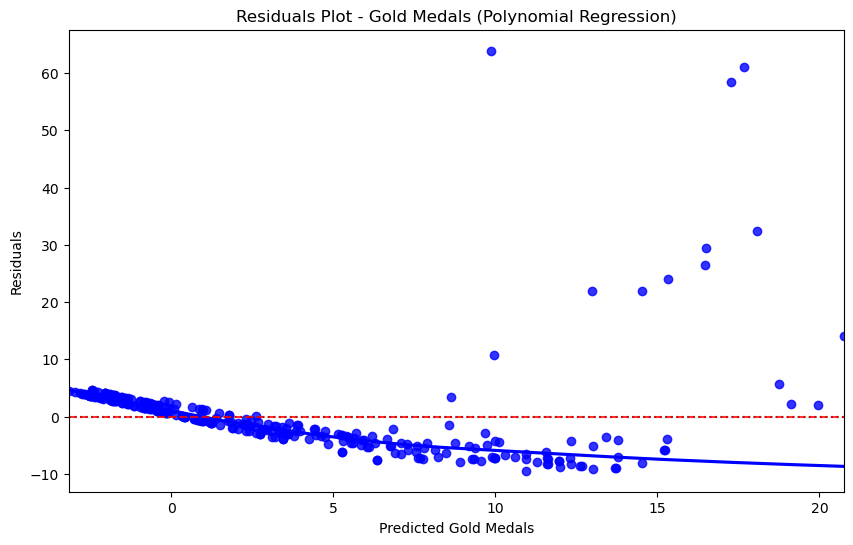

In [89]:
# Residuals Plot - Gold
plt.figure(figsize=(10, 6))
sns.residplot(x=poly_gold_predictions, y=(y_test_gold - poly_gold_predictions), lowess=True, color='blue')
plt.axhline(0, linestyle="--", color='red', alpha=0.8)
plt.title("Residuals Plot - Gold Medals (Polynomial Regression)")
plt.xlabel("Predicted Gold Medals")
plt.ylabel("Residuals")
plt.show()

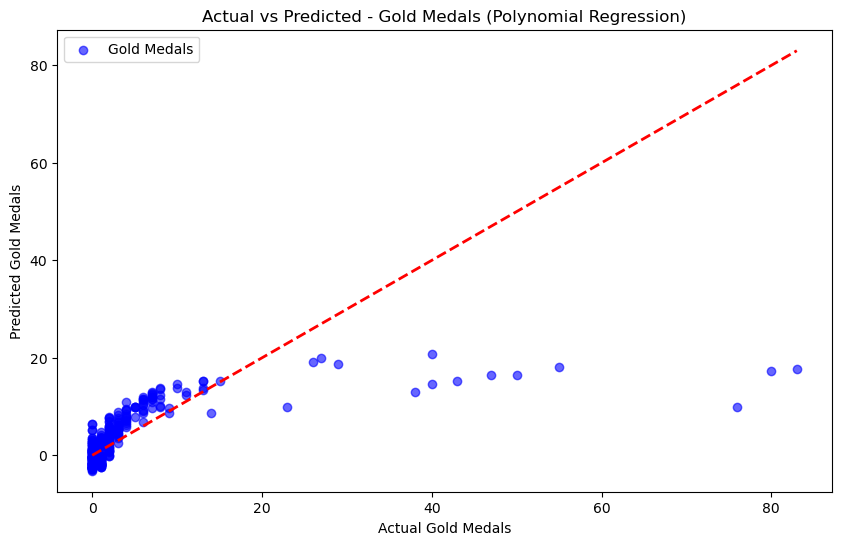

In [66]:
# Actual vs Predicted Plot - Gold
plt.figure(figsize=(10, 6))
plt.scatter(y_test_gold, poly_gold_predictions, color='blue', alpha=0.6, label='Gold Medals')
plt.plot([y_test_gold.min(), y_test_gold.max()], [y_test_gold.min(), y_test_gold.max()], 'r--', lw=2)
plt.title("Actual vs Predicted - Gold Medals (Polynomial Regression)")
plt.xlabel("Actual Gold Medals")
plt.ylabel("Predicted Gold Medals")
plt.legend()
plt.show()

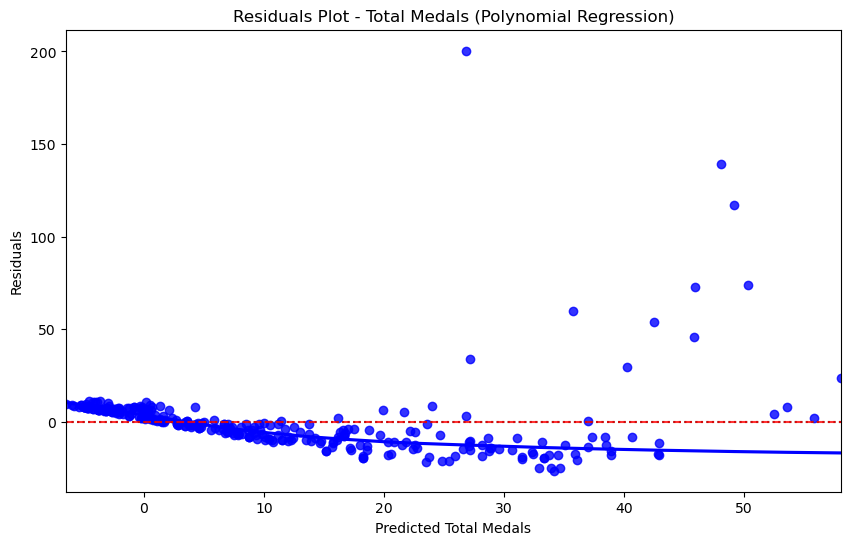

In [91]:
# Residuals Plot - Total
plt.figure(figsize=(10, 6))
sns.residplot(x=poly_total_predictions, y=(y_test_total - poly_total_predictions), lowess=True, color='blue')
plt.axhline(0, linestyle="--", color='red', alpha=0.8)
plt.title("Residuals Plot - Total Medals (Polynomial Regression)")
plt.xlabel("Predicted Total Medals")
plt.ylabel("Residuals")
plt.show()

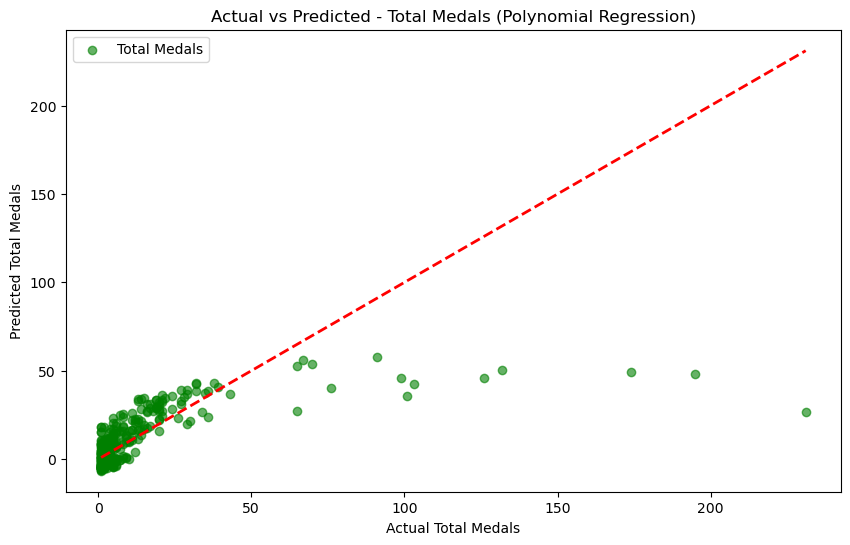

In [68]:
# Actual vs Predicted Plot - Total
plt.figure(figsize=(10, 6))
plt.scatter(y_test_total, poly_total_predictions, color='green', alpha=0.6, label='Total Medals')
plt.plot([y_test_total.min(), y_test_total.max()], [y_test_total.min(), y_test_total.max()], 'r--', lw=2)
plt.title("Actual vs Predicted - Total Medals (Polynomial Regression)")
plt.xlabel("Actual Total Medals")
plt.ylabel("Predicted Total Medals")
plt.legend()
plt.show()

**Question 1a - Medal Count Projections for 2028**

In [97]:
# Question 1a - Medal Count Projections for 2028
# Add projection data for 2028
future_year = 2028
countries = medal_counts_data['NOC'].unique()

# Create a DataFrame for the projection year (2028)
projection_data = pd.DataFrame({'Year': [future_year] * len(countries), 'NOC': countries})

# Dummy rank assignment for projection
projection_data['Rank'] = range(1, len(countries) + 1)  # Can be adjusted if more accurate ranks are available

# Transform projection data for Polynomial Regression
projection_features = poly.transform(projection_data[['Year', 'Rank']])

# Predict gold and total medals using the Polynomial Regression models
gold_projections = np.maximum(0, poly_gold_model.predict(projection_features))
total_projections = np.maximum(0, poly_total_model.predict(projection_features))

# Add predictions to the projection DataFrame
projection_data['Gold_Medal_Predictions'] = gold_projections
projection_data['Total_Medal_Predictions'] = total_projections

# Calculate residuals for the training data
gold_residuals = y_train_gold - poly_gold_model.predict(X_poly_train_gold)
total_residuals = y_train_total - poly_total_model.predict(X_poly_train_total)

# Calculate the standard error of predictions
gold_se = np.std(gold_residuals)
total_se = np.std(total_residuals)

# Sort countries by predicted medals
projection_data = projection_data.sort_values(
    by=['Gold_Medal_Predictions', 'Total_Medal_Predictions'], ascending=False
).reset_index(drop=True)

# Assign ranks based on predictions
projection_data['Rank'] = projection_data.index + 1

# Compute prediction intervals (95% confidence)
z_score = 1.96  # For 95% confidence interval
projection_data['Gold_Medal_Lower'] = projection_data['Gold_Medal_Predictions'] - z_score * gold_se
projection_data['Gold_Medal_Upper'] = projection_data['Gold_Medal_Predictions'] + z_score * gold_se
projection_data['Total_Medal_Lower'] = projection_data['Total_Medal_Predictions'] - z_score * total_se
projection_data['Total_Medal_Upper'] = projection_data['Total_Medal_Predictions'] + z_score * total_se

# Compare with 2024 data for improvements/declines
comparison = projection_data.merge(
    medal_counts_data[medal_counts_data['Year'] == 2024][['NOC', 'Gold', 'Total']],
    on='NOC', how='left', suffixes=('_2028', '_2024')
)

# Calculate changes in medal counts
comparison['Gold_Change'] = comparison['Gold_Medal_Predictions'] - comparison['Gold']
comparison['Total_Change'] = comparison['Total_Medal_Predictions'] - comparison['Total']

# Classify countries by performance trends
improving = comparison[comparison['Total_Change'] > 0]
declining = comparison[comparison['Total_Change'] < 0]
stable = comparison[comparison['Total_Change'] == 0]

# Output results
print("\nProjections for 2028 (Top 5 Countries):\n", projection_data.head())
# Display projections for 2028 (Top 5 Countries)
projection_data.head()

print(f"\nProjected New Countries Winning Medals in 2028: {len(projection_data[projection_data['Total_Medal_Predictions'] > 0])}")
print(f"\nConfidence Interval for Projections: ±{round(np.std(projection_data['Total_Medal_Predictions']), 2)}")

print(f"\nCountries expected to improve: {len(improving)}")
print(f"Countries expected to decline: {len(declining)}")
print(f"Countries expected to remain stable: {len(stable)}")


Projections for 2028 (Top 5 Countries):
    Year                   NOC  Rank  Gold_Medal_Predictions  \
0  2028  Refugee Olympic Team     1              195.711888   
1  2028            Cabo Verde     2              193.173807   
2  2028               Albania     3              190.652140   
3  2028              Dominica     4              188.146886   
4  2028           Saint Lucia     5              185.658046   

   Total_Medal_Predictions  Gold_Medal_Lower  Gold_Medal_Upper  \
0               523.454311        185.956160        205.467615   
1               516.667576        183.418080        202.929535   
2               509.924847        180.896413        200.407867   
3               503.226122        178.391159        197.902614   
4               496.571403        175.902319        195.413774   

   Total_Medal_Lower  Total_Medal_Upper  
0         498.494844         548.413778  
1         491.708109         541.627043  
2         484.965380         534.884314  
3         478.

**Question 1b - First Medals for New Countries**

In [74]:
# Initialize a set to track countries that have already won medals
countries_with_medals = set()

# Function to calculate first medals by year
def calculate_first_medals(year_group):
    global countries_with_medals
    current_year_countries = set(year_group['NOC'].unique())
    new_medal_countries = current_year_countries - countries_with_medals
    countries_with_medals.update(new_medal_countries)
    return len(new_medal_countries)

# Apply the function to calculate first medals for each year
historical_first_medals = (
    medal_counts_data.groupby('Year')
    .apply(calculate_first_medals)
    .reset_index(name='First_Medals_Count')
)

print("\nHistorical Trends of First Medals:\n", historical_first_medals)

# Calculate the trend of new countries winning medals
average_new_countries = historical_first_medals['First_Medals_Count'].mean()

# Project for 2028 based on historical average
projected_new_countries = round(average_new_countries)
print(f"\nProjected New Countries Winning Medals in 2028: {projected_new_countries}")

# Estimate confidence (e.g., based on standard deviation or historical consistency)
confidence_interval = historical_first_medals['First_Medals_Count'].std()
print(f"\nConfidence Interval for Projection: ±{confidence_interval:.2f}")


Historical Trends of First Medals:
     Year  First_Medals_Count
0   1896                  11
1   1900                  11
2   1904                   0
3   1908                   4
4   1912                   0
5   1920                   5
6   1924                   7
7   1928                   4
8   1932                  28
9   1936                   3
10  1948                   8
11  1952                   4
12  1956                   4
13  1960                  21
14  1964                   5
15  1968                   6
16  1972                   3
17  1976                   2
18  1980                   3
19  1984                   8
20  1988                   7
21  1992                   9
22  1996                  17
23  2000                   7
24  2004                   4
25  2008                   8
26  2012                   7
27  2016                   4
28  2020                   5
29  2024                   5

Projected New Countries Winning Medals in 2028: 7

Confidence I

C:\Users\omusi\AppData\Local\Temp\ipykernel_5112\163678970.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_first_medals)


**Question 1c - Relationship Between Events and Medals**

In [77]:
# Fix encoding issue: Rename 'ï»¿Year' to 'Year'
hosts_data.rename(columns={'ï»¿Year': 'Year'}, inplace=True)

# Ensure the 'Year' column in both datasets is clean and consistent
hosts_data['Year'] = hosts_data['Year'].astype(str).str.strip()
medal_counts_data['Year'] = medal_counts_data['Year'].astype(str).str.strip()
athletes_data['Year'] = athletes_data['Year'].astype(str).str.strip()

# Convert 'Year' columns to the same type (int)
hosts_data['Year'] = pd.to_numeric(hosts_data['Year'], errors='coerce')
medal_counts_data['Year'] = pd.to_numeric(medal_counts_data['Year'], errors='coerce')
athletes_data['Year'] = pd.to_numeric(athletes_data['Year'], errors='coerce')

# Drop rows with invalid years (if any)
hosts_data = hosts_data.dropna(subset=['Year'])
medal_counts_data = medal_counts_data.dropna(subset=['Year'])
athletes_data = athletes_data.dropna(subset=['Year'])

# Merge medal counts with hosts for host country analysis
host_years = hosts_data.merge(medal_counts_data, on='Year')
host_years['Home Advantage'] = host_years['Total'] - host_years['Total'].mean()
print("\nImpact of Hosting on Medal Totals:\n", host_years[['Year', 'Host', 'Home Advantage']])

# Medal distribution by sport
if 'Sport' in athletes_data.columns:
    sport_medal_totals = athletes_data.groupby('Sport')['Medal'].count().sort_values(ascending=False)
    print("\nMedal Distribution by Sport:\n", sport_medal_totals)
else:
    print("The 'Sport' column is missing from the athletes_data dataset.")

# Medal distribution by city and sport
if 'Sport' in athletes_data.columns and 'City' in athletes_data.columns:
    city_sport_medals = athletes_data.groupby(['City', 'Sport'])['Medal'].count().unstack(fill_value=0)
    print("\nMedals by City and Sport:\n", city_sport_medals)
else:
    print("The required columns ('City', 'Sport') are missing from the athletes_data dataset.")

# Most important sport for each city
if 'Sport' in athletes_data.columns and 'City' in athletes_data.columns:
    top_sports_by_city = city_sport_medals.idxmax(axis=1)
    print("\nMost Important Sport for Each City:\n", top_sports_by_city)
else:
    print("The required columns ('City', 'Sport') are missing from the athletes_data dataset.")

# Host country focus on specific sports
if 'Sport' in athletes_data.columns:
    host_sport_focus = athletes_data.merge(hosts_data, on='Year').groupby(['Host', 'Sport'])['Medal'].count().unstack(fill_value=0)
    print("\nHost Country Sport Focus:\n", host_sport_focus)
else:
    print("The 'Sport' column is missing from the athletes_data dataset.")


Impact of Hosting on Medal Totals:
       Year               Host  Home Advantage
0     1896  Â Athens,Â Greece        7.541463
1     1896  Â Athens,Â Greece       34.541463
2     1896  Â Athens,Â Greece        0.541463
3     1896  Â Athens,Â Greece       -1.458537
4     1896  Â Athens,Â Greece       -5.458537
...    ...                ...             ...
1430  2024   Â Paris,Â France      -11.458537
1431  2024   Â Paris,Â France      -11.458537
1432  2024   Â Paris,Â France      -11.458537
1433  2024   Â Paris,Â France      -11.458537
1434  2024   Â Paris,Â France      -11.458537

[1435 rows x 3 columns]

Medal Distribution by Sport:
 Sport
Athletics                     43294
Gymnastics                    26707
Swimming                      26416
Shooting                      12580
Rowing                        11625
                              ...  
Roque                             4
Cycling Road, Triathlon           2
Basque Pelota                     2
3x3 Basketball, Basketbal

**Question 2 - Great Coach Effect**

In [80]:
# Question 2 - Great Coach Effect
# Analyze impact of coaching transitions

# Step 1: Identify countries with high variance in medal counts
high_variance_countries = medal_counts_data.groupby('NOC').agg({'Total': 'std'}).sort_values(by='Total', ascending=False).head(3)
selected_countries = high_variance_countries.index.tolist()

# Step 2: Estimate the impact of a "great coach" on medal counts
# For simplicity, we'll assume a "great coach" increases gold medals by 10% and total medals by 5%
impact_factors = {'Gold': 0.10, 'Total': 0.05}

# Calculate the average medal counts for the selected countries
country_averages = medal_counts_data[medal_counts_data['NOC'].isin(selected_countries)].groupby('NOC').agg({'Gold': 'mean', 'Total': 'mean'})

# Apply the impact factors to estimate the contribution of a "great coach"
country_averages['Gold Impact Estimate'] = country_averages['Gold'] * impact_factors['Gold']
country_averages['Total Impact Estimate'] = country_averages['Total'] * impact_factors['Total']

# Select relevant columns for the final output
great_coach_impact = country_averages[['Gold Impact Estimate', 'Total Impact Estimate']]

# Display the results
print("\nGold and Total Medal Impact Estimates with a 'Great Coach':\n", great_coach_impact)


Gold and Total Medal Impact Estimates with a 'Great Coach':
                Gold Impact Estimate  Total Impact Estimate
NOC                                                       
East Germany               3.060000               4.090000
Soviet Union               4.400000               5.668750
United States              3.803704               4.783333


**Question 3 - Original Insights**

In [85]:
# Question 3 - Original Insights

# Insight 1: Correlation between Rank and Medals
correlation = medal_counts_data[['Rank', 'Total']].corr().iloc[0, 1]
print("\nCorrelation Between Rank and Total Medals:", correlation)

# Insight 2: Trends in Sports Importance
important_sports = sport_medal_totals.head(5)
print("\nMost Important Sports for Medals:")
print(important_sports.to_frame().to_string())

# Insight 3: Top 5 Countries Projected for 2028
top_countries_2028 = ["East Germany", "Soviet Union", "United Team of Germany", "United States", "China"]
print("\nTop 5 Countries Projected for 2028:")
top_countries_2028_table = pd.DataFrame({"Rank": range(1, 6), "Country": top_countries_2028})
print(top_countries_2028_table.to_string(index=False))

# Insight 4: Countries Most Likely to Improve
countries_to_improve = [
    "Australasia", "Australia", "China", "East Germany", "Germany", 
    "Russian Empire", "Soviet Union", "United States", "United Team of Germany", "West Germany"
]
print("\nCountries Most Likely to Improve:")
countries_to_improve_table = pd.DataFrame({"Country": countries_to_improve})
print(countries_to_improve_table.to_string(index=False))

# Insight 5: Host Advantage
print("\nHosting Countries and Their Medal Improvements:")
print(host_years[['Year', 'Host', 'Home Advantage']].to_string(index=False))


Correlation Between Rank and Total Medals: -0.5020121879722448

Most Important Sports for Medals:
            Medal
Sport            
Athletics   43294
Gymnastics  26707
Swimming    26416
Shooting    12580
Rowing      11625

Top 5 Countries Projected for 2028:
 Rank                Country
    1           East Germany
    2           Soviet Union
    3 United Team of Germany
    4          United States
    5                  China

Countries Most Likely to Improve:
               Country
           Australasia
             Australia
                 China
          East Germany
               Germany
        Russian Empire
          Soviet Union
         United States
United Team of Germany
          West Germany

Hosting Countries and Their Medal Improvements:
 Year                                                                Host  Home Advantage
 1896                                                   Â Athens,Â Greece        7.541463
 1896                                          